# Student Pass/Fail Prediction — End-to-End

**Goal:** build a model that predicts whether a student `Passed` (Yes/No) from features:
`StudyHours, Attendance, PastScore, Internet, SleepHours`.

**Plan (high-level):**
1. Load & understand data (EDA)
2. Preprocess / clean
3. Feature engineering & selection
4. Feature scaling (if needed)
5. Train/test split (stratified)
6. Baseline models
7. Model evaluation (multiple metrics)
8. Improve (hyperparameter tuning, resampling, ensembles)
9. Visualize results
10. Save / export model
11. Notes, pitfalls, next experiments

**Notes on choices:** binary classification. Use accuracy *and* precision/recall/F1/ROC-AUC. Always stratify splits. Try simple interpretable models first (Logistic Regression, Decision Tree) then ensembles (RandomForest, XGBoost).


In [1]:
# Cell: prerequisites & imports
# Run this cell first.
import pandas as pd
import numpy as np

# Modeling and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve
)

# Optional: XGBoost (install if available)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look okay
%matplotlib inline
sns.set(style="whitegrid")

## 1) Load data and initial checks

**What to do:** read the CSV, inspect first rows, shape, dtypes, missing values, basic stats.  
**Why:** get a clear baseline of what you actually have — many errors arise from bad assumptions.


In [2]:
# Cell: load & initial checks
df = pd.read_csv('data.csv')   # change path if needed

# Quick peek
print("First 10 rows:")
display(df.head(10))

print("\nShape:", df.shape)
print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nUnique values for categorical columns (if any):")
for col in df.select_dtypes(include='object').columns:
    print(col, "->", df[col].unique())

print("\nStatistical summary (numerical):")
display(df.describe())


First 10 rows:


,StudyHours,Attendance,PastScore,Internet,SleepHours,Passed
0,2,60,40,No,5,No
1,5,80,60,No,6,Yes
2,8,90,75,Yes,8,Yes
3,3,70,50,Yes,5,No
4,7,85,70,No,7,Yes
5,1,50,30,No,4,No
6,6,78,68,Yes,6,Yes
7,4,65,55,No,5,No
8,9,95,80,Yes,9,Yes
9,2,55,35,No,4,No



Shape: (20, 6)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StudyHours  20 non-null     int64 
 1   Attendance  20 non-null     int64 
 2   PastScore   20 non-null     int64 
 3   Internet    20 non-null     object
 4   SleepHours  20 non-null     int64 
 5   Passed      20 non-null     object
dtypes: int64(4), object(2)
memory usage: 1.1+ KB
None

Missing values per column:
StudyHours    0
Attendance    0
PastScore     0
Internet      0
SleepHours    0
Passed        0
dtype: int64

Unique values for categorical columns (if any):
Internet -> ['No' 'Yes']
Passed -> ['No' 'Yes']

Statistical summary (numerical):


,StudyHours,Attendance,PastScore,SleepHours
count,20.000000,20.000000,20.00000,20.000000
mean,5.100000,74.150000,59.10000,6.050000
std,2.845125,17.372922,19.41215,2.038446
min,1.000000,40.000000,25.00000,3.000000
25%,2.750000,60.000000,43.75000,4.750000
50%,5.000000,77.000000,62.50000,6.000000
75%,7.250000,88.500000,72.75000,7.250000
max,10.000000,99.000000,90.00000,10.000000


## 2) Exploratory Data Analysis (EDA)

**What:** distributions, correlations, class balance, simple plots.  
**Why:** detect outliers, skew, class imbalance, feature relevance.

**Things to check specifically:**
- Count of `Passed` vs `No` (class balance).
- Correlation matrix between numeric features and `Passed` (encode target first).
- Distribution plots: StudyHours, Attendance, PastScore, SleepHours.
- Boxplots to reveal outliers.


Class counts:
Passed
Yes    11
No      9
Name: count, dtype: int64 



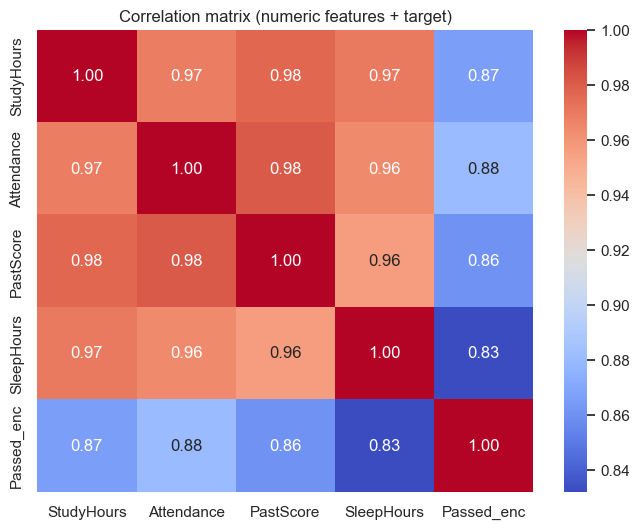

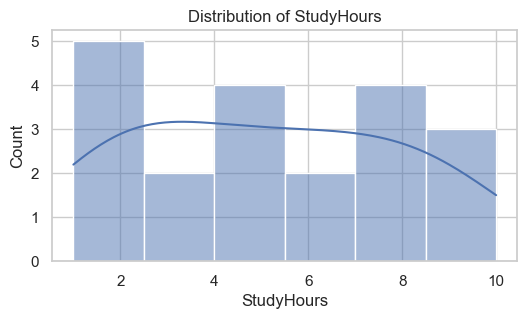

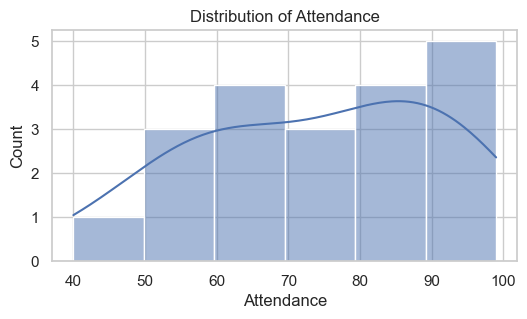

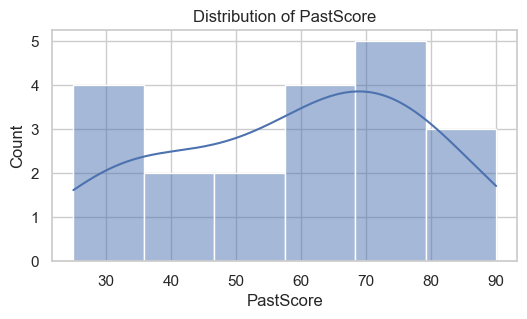

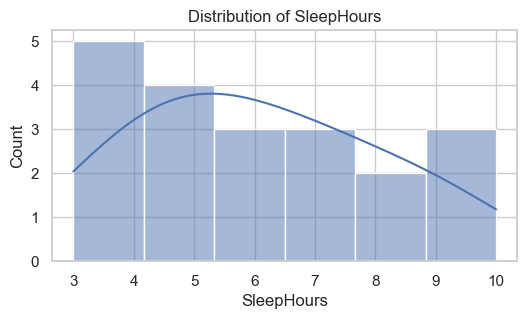

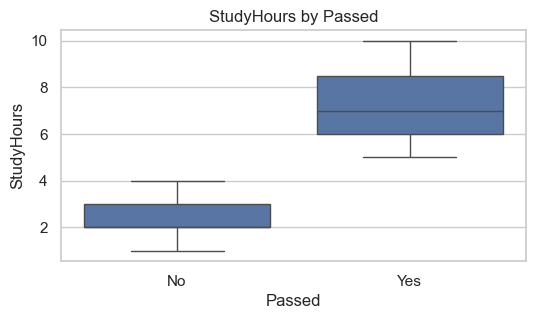

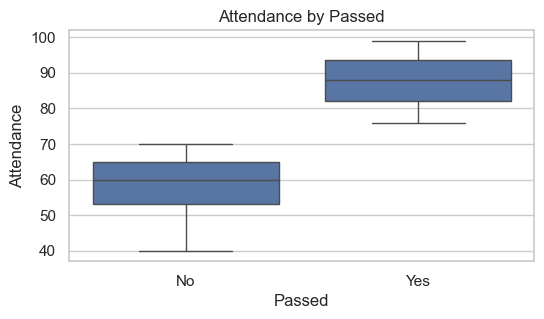

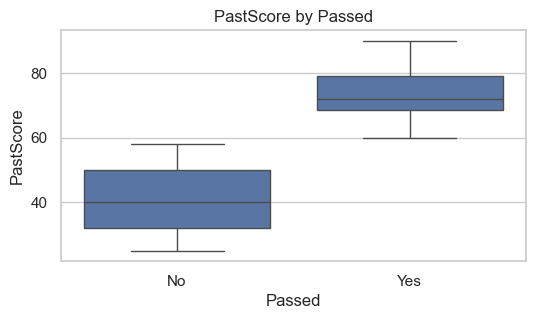

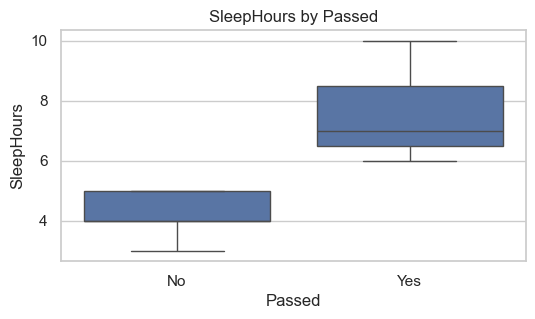

In [3]:
# Cell: EDA
# Encode Passed temporarily for correlation
tmp = df.copy()
tmp['Passed_enc'] = tmp['Passed'].map({'Yes':1, 'No':0})

print("Class counts:")
print(tmp['Passed'].value_counts(), "\n")

# Correlation
corr = tmp.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix (numeric features + target)")
plt.show()

# Distribution plots
num_cols = ['StudyHours','Attendance','PastScore','SleepHours']
for c in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[c], kde=True)
    plt.title(f"Distribution of {c}")
    plt.show()

# Boxplots vs target
for c in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='Passed', y=c, data=df)
    plt.title(f"{c} by Passed")
    plt.show()


## 3) Preprocessing: cleaning and encoding

**What to do (ordered):**
1. Fix dtypes (ensure numeric cols are numeric).
2. Handle missing values (impute or drop).
3. Encode categorical variables:
   - `Internet` is binary (`Yes`/`No`) — use 0/1.
   - `Passed` is the target — convert to 0/1 (`No` => 0, `Yes` => 1).
4. Optionally create new features or bin continuous variables.
5. Save preprocessing pipeline for reuse.

**Why:** consistent numeric inputs to models and reproducible transformations.


In [4]:
# Cell: preprocessing basics
df2 = df.copy()

# 1) enforce numeric types (coerce errors to NaN so we can handle them)
numeric_cols = ['StudyHours','Attendance','PastScore','SleepHours']
for c in numeric_cols:
    df2[c] = pd.to_numeric(df2[c], errors='coerce')

# 2) encode Internet and Passed
df2['Internet'] = df2['Internet'].map({'Yes':1, 'No':0})
df2['Passed'] = df2['Passed'].map({'Yes':1, 'No':0})

print("After conversions:")
print(df2.dtypes)
print("\nMissing values after conversion:")
print(df2.isnull().sum())

# 3) If there were missing values, we would impute. In this dataset, likely none.


After conversions:
StudyHours    int64
Attendance    int64
PastScore     int64
Internet      int64
SleepHours    int64
Passed        int64
dtype: object

Missing values after conversion:
StudyHours    0
Attendance    0
PastScore     0
Internet      0
SleepHours    0
Passed        0
dtype: int64


### Handling missing values — rules and options

**If missing values exist:**
- Numeric: impute with mean/median or use KNN imputer if appropriate. Use median if data skewed.
- Categorical: impute most frequent or use a new category "Missing".
- If a column has >30%-50% missing, consider dropping it.

**Code (example):**


In [5]:
# Example imputation pipeline (uncomment if necessary)
num_imputer = SimpleImputer(strategy='median')  # median recommended when skew exists
cat_imputer = SimpleImputer(strategy='most_frequent')

# Example usage:
# df2[numeric_cols] = num_imputer.fit_transform(df2[numeric_cols])
# df2['Internet'] = cat_imputer.fit_transform(df2[['Internet']])


## 4) Feature engineering & selection (practical ideas)

**Ideas to try:**
- `StudyHours * Attendance/100` -> combined engagement metric.
- `PastScore` binning: low/medium/high (useful for tree models).
- `SleepHours` squared or banded (very low or very high sleep might correlate with fail).
- Interaction terms: `StudyHours * PastScore`.
- Use correlation and feature importances to drop weak features.

**Why:** improves signals, sometimes simple ratios are more predictive than raw features.


In [6]:
# Cell: sample feature engineering
df3 = df2.copy()
df3['Engagement'] = df3['StudyHours'] * (df3['Attendance']/100)
df3['Study_Past_interaction'] = df3['StudyHours'] * df3['PastScore']

# Optional binning for PastScore (example)
df3['PastScore_band'] = pd.cut(df3['PastScore'], bins=[0,50,70,100], labels=[0,1,2])  # 0:low,1:mid,2:high

display(df3.head())


,StudyHours,Attendance,PastScore,Internet,SleepHours,Passed,Engagement,Study_Past_interaction,PastScore_band
0,2,60,40,0,5,0,1.20,80,0
1,5,80,60,0,6,1,4.00,300,1
2,8,90,75,1,8,1,7.20,600,2
3,3,70,50,1,5,0,2.10,150,0
4,7,85,70,0,7,1,5.95,490,1


## 5) Feature scaling — when and how

**Rules of thumb:**
- Tree-based models (DecisionTree, RandomForest, XGBoost) do NOT require scaling.
- Distance-based models (KNN, SVM with RBF, LogisticRegression with regularization) *benefit* from scaling.
- If you plan a pipeline with multiple model types, include a scaler option in pipeline.

**Common scalers:**
- `StandardScaler` (zero mean, unit variance) — default for many models.
- `MinMaxScaler` — preserves [0,1]; useful when features have different ranges.
- `RobustScaler` — robust to outliers.

We'll set up a pipeline so scaling is applied only to numeric features where needed.


In [7]:
# Cell: Prepare features and target
# Choose feature set (drop helper columns if you added them but don't want them)
features = ['StudyHours','Attendance','PastScore','Internet','SleepHours','Engagement','Study_Past_interaction']
X = df3[features].copy()
y = df3['Passed'].copy()

# Train-test split (stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class distribution:\n", y_train.value_counts(normalize=True))


Train shape: (16, 7) Test shape: (4, 7)
Train class distribution:
 Passed
1    0.5625
0    0.4375
Name: proportion, dtype: float64


## 6) Baseline models & quick benchmarking

**Approach:** make a function that trains multiple models with minimal tuning and prints evaluation metrics.  
**Models to try initially:** Logistic Regression, Decision Tree, RandomForest, KNN, SVM, Naive Bayes, (XGBoost if available).

**Metrics:** Accuracy, Precision, Recall, F1, ROC-AUC. Use `cross_val_score` for a more robust estimate.


Model: LogisticRegression
Accuracy: 1.000  Precision: 1.000  Recall: 1.000  F1: 1.000  ROC-AUC: 1.000


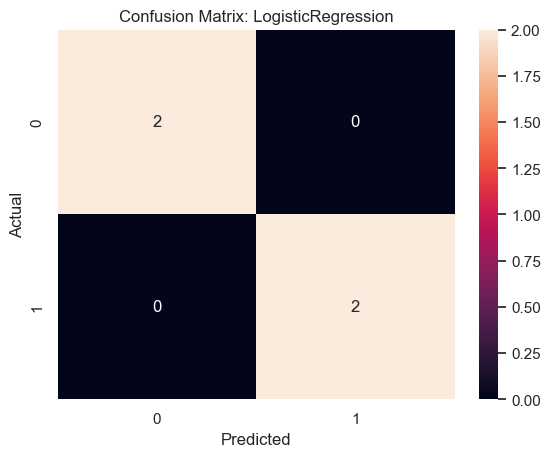

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

------------------------------------------------------------
Model: DecisionTreeClassifier
Accuracy: 1.000  Precision: 1.000  Recall: 1.000  F1: 1.000  ROC-AUC: 1.000


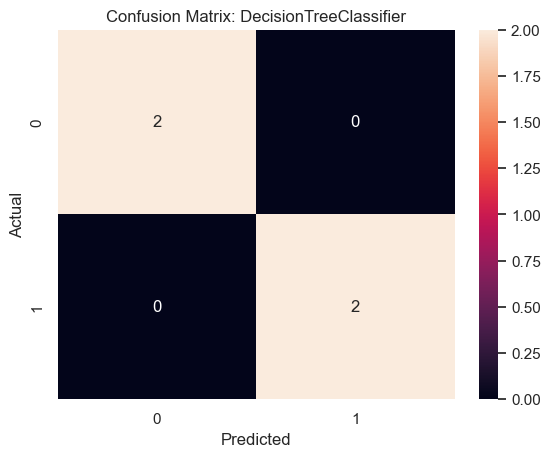

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

------------------------------------------------------------
Model: RandomForestClassifier
Accuracy: 1.000  Precision: 1.000  Recall: 1.000  F1: 1.000  ROC-AUC: 1.000


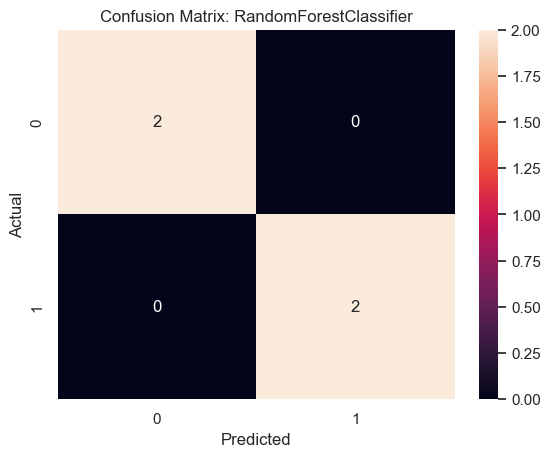

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

------------------------------------------------------------
Model: KNeighborsClassifier
Accuracy: 1.000  Precision: 1.000  Recall: 1.000  F1: 1.000  ROC-AUC: 1.000


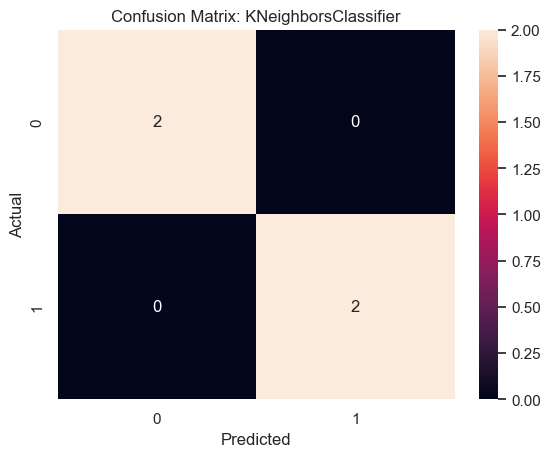

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

------------------------------------------------------------
Model: SVC
Accuracy: 1.000  Precision: 1.000  Recall: 1.000  F1: 1.000  ROC-AUC: 1.000


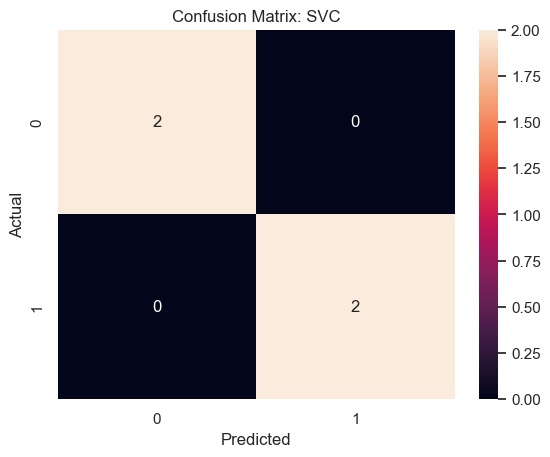

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

------------------------------------------------------------
Model: GaussianNB
Accuracy: 1.000  Precision: 1.000  Recall: 1.000  F1: 1.000  ROC-AUC: 1.000


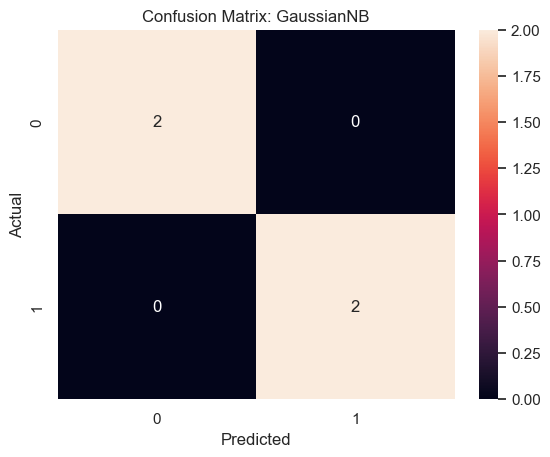

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

------------------------------------------------------------


In [8]:
# Cell: helper functions for training and evaluating models
def evaluate_model(model, X_train, y_train, X_test, y_test, show_cm=True):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    proba = None
    try:
        proba = model.predict_proba(X_test)[:,1]
    except Exception:
        pass

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    roc = roc_auc_score(y_test, proba) if proba is not None else None

    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}  ROC-AUC: {roc if roc is None else f'{roc:.3f}'}")
    if show_cm:
        cm = confusion_matrix(y_test, preds)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title(f'Confusion Matrix: {model.__class__.__name__}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    print(classification_report(y_test, preds, zero_division=0))
    print("-"*60)

# Baseline models (scaled where appropriate)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = [
    LogisticRegression(max_iter=200),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(n_estimators=100, random_state=42),
    KNeighborsClassifier(n_neighbors=5),
    SVC(probability=True),
    GaussianNB()
]

for m in models:
    # for tree-based models, use unscaled; for others, use scaled
    if isinstance(m, (DecisionTreeClassifier, RandomForestClassifier)):
        evaluate_model(m, X_train, y_train, X_test, y_test)
    else:
        evaluate_model(m, X_train_scaled, y_train, X_test_scaled, y_test)


## 7) Interpretation & what to watch for

- If Logistic Regression performs close to RandomForest, your problem may be linearly separable; use LR and interpret coefficients.
- If tree models beat linear models, there are non-linear interactions — check feature importances.
- If recall for positive class is low, and your business concern is to *catch* students who will fail, prioritize recall (or F1) and use class_weight or resampling.
- ROC-AUC matters when you care about ranking. PR-AUC matters when classes are imbalanced.


Feature importances (RandomForest):


StudyHours                0.185
Engagement                0.185
Attendance                0.160
PastScore                 0.160
SleepHours                0.150
Study_Past_interaction    0.145
Internet                  0.015
dtype: float64

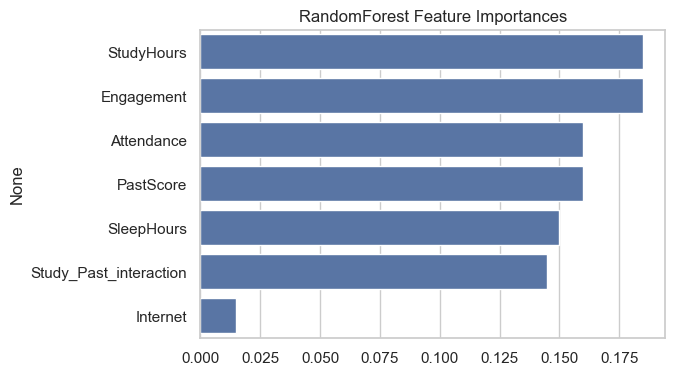

In [9]:
# Cell: Example — feature importances from RandomForest
rf = RandomForestClassifier(random_state=42, n_estimators=200)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Feature importances (RandomForest):")
display(importances)

plt.figure(figsize=(6,4))
sns.barplot(x=importances.values, y=importances.index)
plt.title("RandomForest Feature Importances")
plt.show()


## 8) Address class imbalance (if present)

**Options:**
1. `class_weight='balanced'` in many classifiers (LogisticRegression, RandomForest, SVM).
2. Resampling:
   - Oversample minority: SMOTE, RandomOverSampler (careful with small datasets).
   - Undersample majority: RandomUnderSampler (can lose data).
3. Use metrics that reflect imbalance: F1, recall, PR-AUC.

**When to use:** If minority class < ~25% or if you care more about one error type.


Model: Pipeline
Accuracy: 1.000  Precision: 1.000  Recall: 1.000  F1: 1.000  ROC-AUC: 1.000


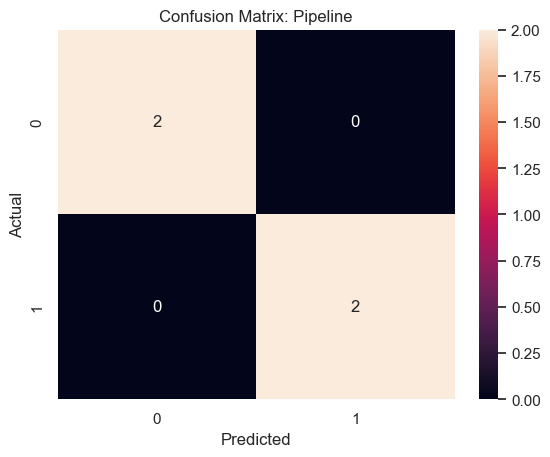

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

------------------------------------------------------------


In [10]:
# Example: logistic regression with class_weight balanced and pipeline with scaler
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', max_iter=500))
evaluate_model(pipe, X_train, y_train, X_test, y_test)


## 9) Hyperparameter tuning (GridSearchCV) — example for RandomForest

**Why:** baseline hyperparameters are rarely optimal. Use cross-validation (StratifiedKFold).  
**Tip:** tune small set of params first, then expand. Keep `n_jobs=-1` for speed.


In [ ]:
# Grid search for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(rf, param_grid, scoring='f1', cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
best_rf = gs.best_estimator_
evaluate_model(best_rf, X_train, y_train, X_test, y_test)


## 10) Advanced experiments (what to try next)

- **XGBoost / LightGBM**: usually better performance; requires separate install.
- **SMOTE**: for small datasets and severe imbalance.
- **Stacking / Blending**: combine Logistic + RandomForest + XGBoost for marginal gains.
- **Calibration**: if you need well-calibrated probabilities, use `CalibratedClassifierCV`.
- **Feature selection**: Recursive Feature Elimination (RFE) or SelectFromModel to reduce noise.
- **K-fold with repeated CV**: get robust performance estimates.


In [ ]:
# Example: using SMOTE (optional)
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print("Resampled class distribution:", np.bincount(y_res))

rf2 = RandomForestClassifier(random_state=42)
rf2.fit(X_res, y_res)
evaluate_model(rf2, X_res, y_res, X_test, y_test)


## 11) Visualize ROC and Precision-Recall curves

**Why:** single-number metrics hide behavior across thresholds. Plot ROC and PR curves to choose thresholds.


In [ ]:
# Plot ROC and PR for best_rf if available
model_to_plot = best_rf if 'best_rf' in globals() else rf

# Ensure probabilities available (use pipeline/scaler if needed)
# If model expects scaled inputs, use scaled test set.
try:
    proba_test = model_to_plot.predict_proba(X_test)[:,1]
except Exception:
    # try scaling
    proba_test = model_to_plot.predict_proba(X_test_scaled)[:,1]

fpr, tpr, _ = roc_curve(y_test, proba_test)
roc_auc = roc_auc_score(y_test, proba_test)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, proba_test)
plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


## 12) Save the final model and preprocessing pipeline

**Why:** to deploy or reuse the model later. Use `joblib` or `pickle`. Save scaler/encoder and model together using a pipeline.


In [ ]:
# Example: make a final pipeline & save it
import joblib  # older sklearn; if missing use plain joblib
import joblib

# Create pipeline (scaler + model)
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_rf if 'best_rf' in globals() else RandomForestClassifier(n_estimators=100, random_state=42))
])

final_pipeline.fit(X, y)  # fit on full data for production

# Save
joblib.dump(final_pipeline, 'student_pass_model.pkl')
print("Saved pipeline to student_pass_model.pkl")


## 13) Practical checklist before deployment

- [ ] Confirm training data is representative of production data.
- [ ] Check feature ranges (outliers) in production.
- [ ] Monitor model drift and performance metrics over time.
- [ ] Add logging for predictions and inputs.
- [ ] Choose thresholds based on business objectives (maximize recall vs precision).
- [ ] If serving probabilities to users, calibrate model.


## 14) Common pitfalls & blunt advice

- **Pitfall:** trusting accuracy only. If classes are imbalanced, accuracy lies.
- **Pitfall:** leaking target info via engineered features (check your pipeline).
- **Pitfall:** small dataset => overfitting. If you have < a few hundred rows, be conservative with complex models.
- **Blunt advice:** start simple. If LogisticRegression with 3 features gives 80% and RandomForest gives 82%, prefer LR for interpretability unless you need the extra 2% and can explain it.
- **If you want to actually improve performance:** collect more data (best ROI), engineer meaningful features (Engagement, changes over time), and apply ensembles carefully.


## 15) Recommended experiments (ordered by likely ROI)

1. Try `Engagement` and interaction terms (you already added them).
2. Cross-validate a Logistic Regression with `class_weight='balanced'`.
3. Tune RandomForest limited grid (done above).
4. Try SMOTE only if classes are unbalanced and you have few positive samples.
5. Try XGBoost/LightGBM if you want extra performance; be careful with hyperparams.
6. Calibrate probabilities if you rely on predicted probabilities.


## 16) Final notes

- Keep your preprocessing code in a reproducible pipeline (scikit-learn `Pipeline` + `ColumnTransformer`) so you can load & serve the model without manual steps.
- Write unit tests for preprocessing (e.g., assert no NaNs after transform).
- Log evaluation metrics and inputs for future debugging.

# End of notebook
